<a href="https://colab.research.google.com/github/Suhit97/StumbleUpon/blob/main/Pytorch_StumbleUpon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/MyDrive/Stumble_Upon/

/content/gdrive/MyDrive/Stumble_Upon


In [16]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip -P /content/gdrive/MyDrive/Stumble_Upon/

--2021-03-01 15:54:48--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘/content/gdrive/MyDrive/Stumble_Upon/wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  14.1MB/s    in 47s     

2021-03-01 15:55:36 (13.8 MB/s) - ‘/content/gdrive/MyDrive/Stumble_Upon/wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [19]:
import zipfile

our_zip = 'wiki-news-300d-1M.vec.zip'
zip_ref = zipfile.ZipFile(our_zip, 'r')
zip_ref.extractall('/content/gdrive/MyDrive/Stumble_Upon/')
zip_ref.close()

In [3]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torchtext import data

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import random
import pickle
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [62]:
train_new = pd.read_csv('new_train.csv')
test_new = pd.read_csv('new_test.csv')
train_new.head()

,urlid,label,joined
0,4042,0,ibm sees holographic calls air breathing batte...
1,8471,1,fully electronic futuristic starting gun elimi...
2,1164,1,fruits fight flu fruits fight flu cold flu men...
3,6684,1,foolproof tips better sleep period life lot pr...
4,9006,0,coolest jerseys know existed coolest jerseys h...


In [63]:
train_new.joined = train_new.joined.astype(str)
test_new.joined = test_new.joined.astype(str)

In [64]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7394 entries, 0 to 7393
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   urlid   7394 non-null   int64 
 1   label   7394 non-null   int64 
 2   joined  7394 non-null   object
dtypes: int64(2), object(1)
memory usage: 173.4+ KB


Not Evergreen: 3599
Evergreen: 3795
Proportion: 0.95 : 1


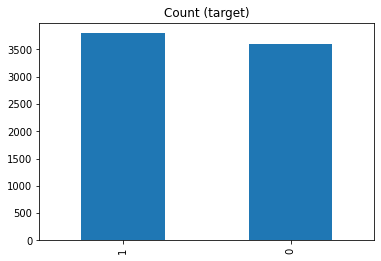

In [65]:
target_count = train_new.label.value_counts()
print('Not Evergreen:', target_count[0])
print('Evergreen:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

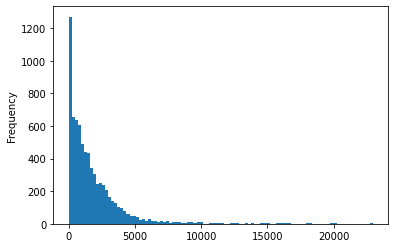

In [66]:
train_new['len'] = train_new['joined'].apply(lambda x : len(x))
train_new['len'].plot.hist(bins=100)

In [67]:

train_df, valid_df = train_test_split(train_new,
                                      test_size=0.25,
                                      random_state=42,
                                      stratify = train_new.label)

In [68]:
copy_df = valid_df.copy()

copy_df

,urlid,label,joined,len
741,1905,1,oven roasted corn chile coconut milk obsessed ...,1526
1462,8326,1,nan,3
990,2136,0,nan,3
2875,1299,1,running songs bpm page workout songs playlists...,172
4881,9062,1,eric oshea elmo impression video eric oshea el...,3721
...,...,...,...,...
5485,282,0,unbelievable chocolate pudding made avocado ye...,1984
6426,5463,1,best brain foods mark daily apple welcome stum...,3360
43,383,1,power foods lower cholesterol high cholesterol...,1006
3958,5942,0,next generation technology flexible display fu...,785


In [11]:
train_df.label.value_counts()

1    2846
0    2699
Name: label, dtype: int64

In [12]:
valid_df.label.value_counts()

1    949
0    900
Name: label, dtype: int64

In [13]:
text_field = data.Field(tokenize = 'spacy', batch_first=True, include_lengths = True)
label_field = data.LabelField(dtype = torch.float, batch_first=True)

In [14]:
class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.label
            text = row.joined
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, False, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)



In [15]:
fields = [('text',text_field), ('label',label_field)]

train_ds, val_ds = DataFrameDataset.splits(fields, train_df=train_df, val_df=valid_df)

In [16]:
from torchtext.vocab import Vectors


vectors = Vectors(name='wiki-news-300d-1M.vec', cache='./')

MAX_VOCAB_SIZE = 100000

text_field.build_vocab(train_ds, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = vectors,
                 unk_init = torch.Tensor.zero_)
label_field.build_vocab(train_ds)

In [17]:


#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(text_field.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(label_field.vocab))

#Commonly used words
print(text_field.vocab.freqs.most_common(10)) 

Size of TEXT vocabulary: 69378
Size of LABEL vocabulary: 2
[('one', 6630), ('like', 5523), ('make', 5362), ('recipe', 4962), ('cup', 4672), ('time', 4484), ('food', 4349), ('minutes', 3888), ('add', 3818), ('get', 3778)]


In [18]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_ds, val_ds), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [19]:
# Hyperparameters
num_epochs = 25
learning_rate = 0.001

INPUT_DIM = len(text_field.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = text_field.vocab.stoi[text_field.pad_token] # padding

In [20]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, text, text_lengths):
       
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
           
        return output

In [21]:
model = LSTMModel(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [23]:
pretrained_embeddings = text_field.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [36]:
def binary_accuracy(preds, y):
    
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [40]:

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [41]:
def evaluate(model, iterator, criterion):
    
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            
            
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [43]:
import time
loss=[]
acc=[]
val_acc=[]
t = time.time()
best_valid_loss = float('inf')

model.to(device) 

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    print(f'\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'\t Val. Loss: {valid_loss:.4f} | Val. Acc: {valid_acc:.4f}')
    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
    
print(f'time:{time.time()-t:.3f}')

	Train Loss: 0.3815 | Train Acc: 0.7953
	 Val. Loss: 0.4663 | Val. Acc: 0.7842
	Train Loss: 0.3097 | Train Acc: 0.8303
	 Val. Loss: 0.5711 | Val. Acc: 0.7632
	Train Loss: 0.2617 | Train Acc: 0.8540
	 Val. Loss: 0.6486 | Val. Acc: 0.7582
	Train Loss: 0.2198 | Train Acc: 0.8685
	 Val. Loss: 0.6402 | Val. Acc: 0.7496
	Train Loss: 0.1960 | Train Acc: 0.8725
	 Val. Loss: 0.9215 | Val. Acc: 0.7407
	Train Loss: 0.1762 | Train Acc: 0.8885
	 Val. Loss: 1.0735 | Val. Acc: 0.7384
	Train Loss: 0.1781 | Train Acc: 0.8806
	 Val. Loss: 0.9831 | Val. Acc: 0.7442
	Train Loss: 0.1862 | Train Acc: 0.8754
	 Val. Loss: 1.0328 | Val. Acc: 0.7413
	Train Loss: 0.1762 | Train Acc: 0.8774
	 Val. Loss: 0.8558 | Val. Acc: 0.7521
	Train Loss: 0.1751 | Train Acc: 0.8809
	 Val. Loss: 1.1716 | Val. Acc: 0.7496
	Train Loss: 0.1704 | Train Acc: 0.8855
	 Val. Loss: 1.2316 | Val. Acc: 0.7535
	Train Loss: 0.1716 | Train Acc: 0.8763
	 Val. Loss: 1.2927 | Val. Acc: 0.7553
	Train Loss: 0.1740 | Train Acc: 0.8795
	 Val. Loss:

In [47]:
#inference 
import spacy
nlp = spacy.load('en')

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [text_field.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    
    prediction = model(tensor, length_tensor).squeeze(1)       #prediction 

    rounded_preds = torch.round(torch.sigmoid(prediction))
    predict_class = rounded_preds.tolist()[0]
    return predict_class



In [ ]:
PATH = "best_model.pt"

model.load_state_dict(torch.load(PATH))

predicts = []

for i in range(len(test_new.joined)):
    predict_class = predict(model, test_new.joined[i])
    predicts.append(int(predict_class))

In [97]:
submission = pd.read_csv("sampleSubmission.csv")
submission['label'] = predicts
submission

,urlid,label
0,5865,0
1,782,1
2,6962,0
3,7640,1
4,3589,0
...,...,...
3166,7264,0
3167,9714,0
3168,5903,1
3169,3176,1


In [94]:
submission.to_csv('submission1.csv',index=False)

In [88]:

another_predicts = []

for i in range(len(train_new.joined)):
    predict_class = predict(model,train_new.joined[i])
    another_predicts.append(int(abs(predict_class - 1)))

In [89]:
copy_df = train_new.copy()
copy_df['predict'] = another_predicts
copy_df

,urlid,label,joined,len,predict
0,4042,0,ibm sees holographic calls air breathing batte...,4687,0
1,8471,1,fully electronic futuristic starting gun elimi...,2264,1
2,1164,1,fruits fight flu fruits fight flu cold flu men...,1141,1
3,6684,1,foolproof tips better sleep period life lot pr...,1789,1
4,9006,0,coolest jerseys know existed coolest jerseys h...,8674,0
...,...,...,...,...,...
7389,8958,0,kno raises million build powerful tablet anyon...,1540,0
7390,8895,0,miss college mar like congratulate jane believ...,643,0
7391,1191,1,sweet potatoes eat im eating loaded vitamin c ...,283,1
7392,5612,1,naturally ella,14,1


In [90]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print('\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(copy_df.label, copy_df.predict))

		CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      3599
           1       0.92      0.85      0.88      3795

    accuracy                           0.88      7394
   macro avg       0.88      0.88      0.88      7394
weighted avg       0.89      0.88      0.88      7394



[Text(0, 0.5, 'FAKE'), Text(0, 1.5, 'REAL')]

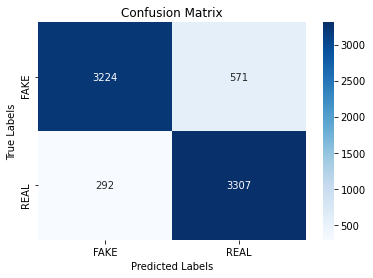

In [91]:
cm = confusion_matrix(copy_df.label, copy_df.predict, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])